In [1]:
# data manipulation
import pandas as pd
import numpy as np

# model training
from sklearn.model_selection import GridSearchCV

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# machine learning models/techniques third parties 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.linear_model as sklm

# for final validation to plot ROC curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from tensorflow import set_random_seed
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Activation, MaxPool2D, Dropout, Flatten
from keras import optimizers, losses
from keras.models import model_from_json


# to time experiments
import time


# to calculate kurtosis and skew
from scipy.stats import kurtosis
from scipy.stats import skew

# for plots
import seaborn as sns 
import matplotlib as pl
import matplotlib.pyplot as plt

import dataexp as dtex # our code
import dataio as dtio # our code 
import preprocessing as pre # our code

# to display pandas and other elements in html
from IPython.display import display
from IPython.core.display import HTML
from IPython.display import Image

# for ordered dictionaries 
from collections import OrderedDict

# for feature extraction
import feature_extraction as fe # our code

# machine learning models/techniques
import model_validation as me # our code
#from decision_tree import DecisionTree # our code
#from random_forest import RandomForest # our code
from logistic_regression import LogisticRegression # our code





# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
x_train_o = pd.read_csv('financial_data.csv')
y_train_o = pd.read_csv('revealed_businesses.csv')

x_test_o = pd.read_csv("testing_data.csv")


In [3]:
x_train_o.replace('?', np.nan, inplace=True)
x_train_o = x_train_o.astype('float64')


x_test_o.replace('?', np.nan, inplace=True)
x_test_o = x_test_o.astype('float64')
#x_test_o.dtypes

,total_instances,total_instances_with_missing_values,total_instances_without_missing_values,data_loss
0,9003.0,4702.0,4301.0,0.5223


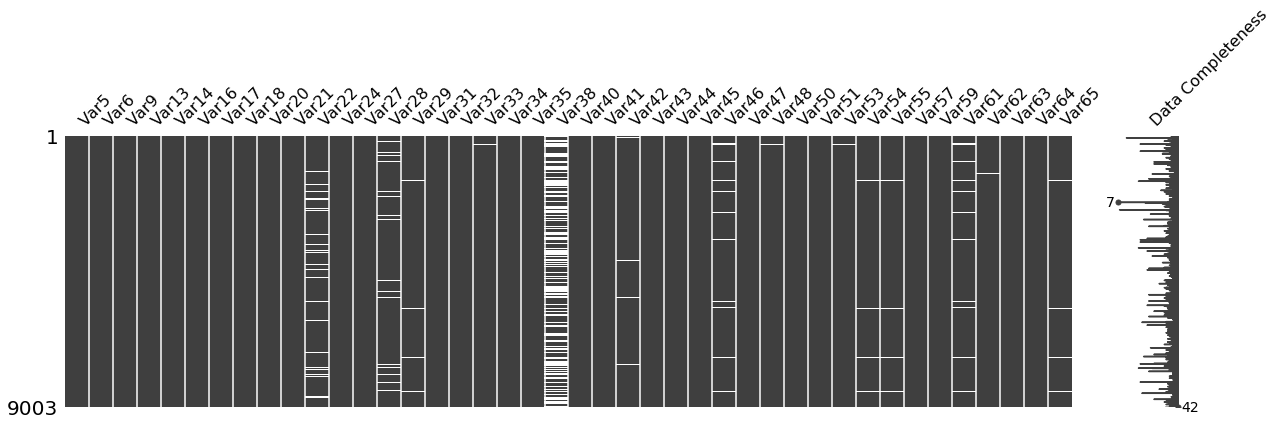

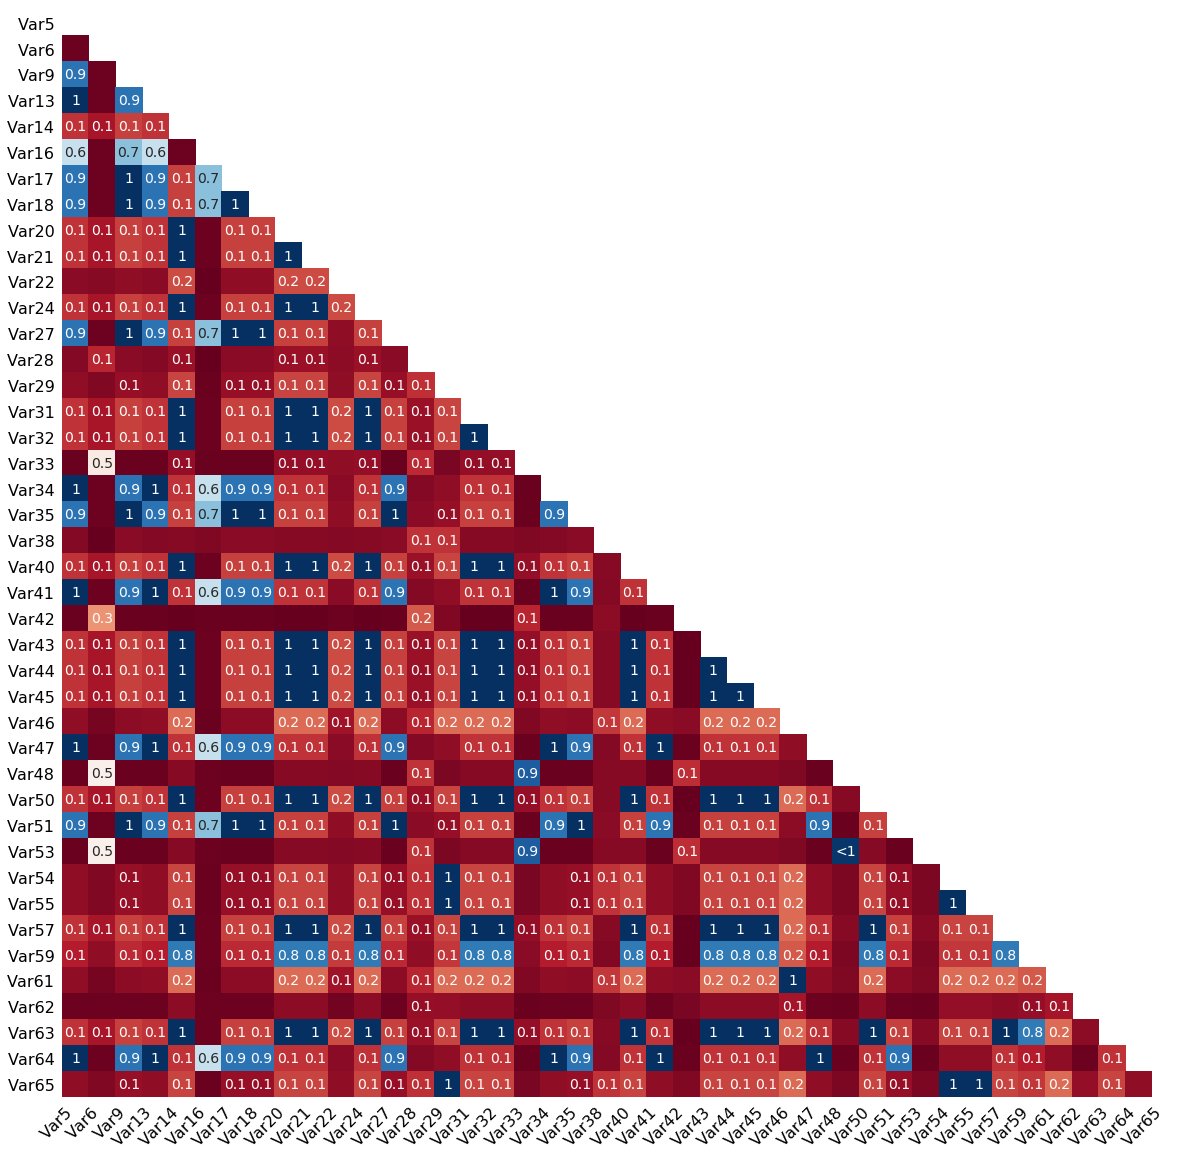

In [35]:
missing_stats_df = dtex.missing_stats(x_train_o)
display(missing_stats_df)

#nullity matrix
dtex.nullity_matrix([x_train_o], include_all = False)

#heatmap - nullity correlation
dtex.nullity_heatmap([x_train_o], include_all = False)


In [5]:
data_train_all = x_train_o.merge(y_train_o, on='Var1', how = 'inner')
data_train_all_id = data_train_all['Var1']
data_train_all = data_train_all.drop(columns=['Var1'])
# x_train=data_train_all.drop(columns=['Var66'])
# y_train=data_train_all['Var66']

In [6]:
x_test_business_id = x_test_o['Var1']
x_test = x_test_o.drop(columns=['Var1'])

In [7]:
imp_mean_dfs = data_train_all.fillna(data_train_all.mean())
imp_mode_dfs = data_train_all.fillna(data_train_all.mode().iloc[0])

In [8]:
# x_train.fillna(x_train.mean(), inplace=True)
# x_test.fillna(x_test.mean(), inplace=True)

In [9]:
imbalanced_stats_df = dtex.imbalanced_stats([imp_mode_dfs],'Var66')
display(imbalanced_stats_df)

,label_0,label_1,minortiy_label,minority_percentage
0,4709.0,170.0,1.0,0.034843


In [10]:
imp_mean_dfs.isnull().sum().sum()

0

In [11]:
os_dfs_dict = OrderedDict()

os_dfs_dict['mean'] = pre.oversample_smote(imp_mean_dfs, columns = imp_mean_dfs.columns, verbose=True)
os_dfs_dict['mode'] = pre.oversample_smote(imp_mode_dfs, columns = imp_mode_dfs.columns, verbose=True)

original dataset (labels): {0: 4709, 1: 170}
total: 4879
resampled dataset (labels): {0: 4709, 1: 4709}
total: 9418

original dataset (labels): {0: 4709, 1: 170}
total: 4879
resampled dataset (labels): {0: 4709, 1: 4709}
total: 9418



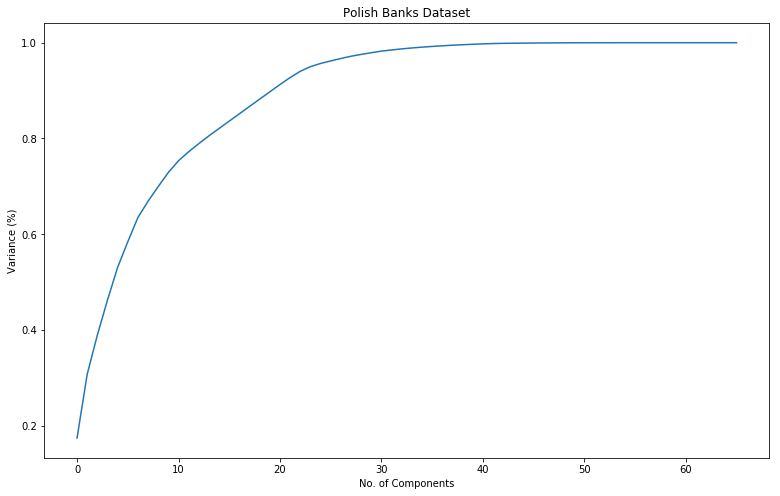

In [12]:
tmp_os_mean = os_dfs_dict['mean'][0]
#s_temp_os_mean = tmp_os_mean[tmp_os_mean.columns[:-1]].apply(pre.standardization, axis = 0)
s_tmp_os_mean = pd.DataFrame(preprocessing.StandardScaler().fit_transform(tmp_os_mean),columns = tmp_os_mean.columns)
s_tmp_os_mean_y = pd.concat([s_tmp_os_mean, tmp_os_mean.iloc[:,-1]], axis = 1)

# apply PCA 
s_tmp_os_mean_pca, pca_instance = fe.pca_reduction(s_tmp_os_mean_y) 

# plot components and variance 
plt.figure(figsize=(13,8))
com_var = np.cumsum(pca_instance.explained_variance_ratio_) 
plt.plot(com_var)
plt.xlabel("No. of Components")
plt.ylabel("Variance (%)")
plt.title("Polish Banks Dataset")
plt.show()


In [13]:
n_components = 29
pca_dfs_dict = OrderedDict()
for key in os_dfs_dict:
    tmp_dfs = []
    for i in range(len(os_dfs_dict[key])):
        # apply standardization to features 
        tmp_standard = os_dfs_dict[key][i][os_dfs_dict[key][i].columns[:-1]].apply(pre.standardization, axis = 0)
        # concat outcome and standardized features
        tmp_standard_y = pd.concat([tmp_standard, os_dfs_dict[key][i].iloc[:,-1]], axis = 1)
        
        # apply feature reduction using PCA (using the same instance)
        tmp_reduction, tmp_pca_instance = fe.pca_reduction(dataframes = tmp_standard_y, 
                                                           n_components = n_components) 
        
        # output components/variance
        tmp_com_var = np.cumsum(tmp_pca_instance.explained_variance_ratio_) 
        print("\tN Components: {0}\n\tWith total variance: {1}%\n\tFeatures removed: {2}"
              .format(n_components, round(tmp_com_var[n_components - 1],4), 
                      os_dfs_dict[key][0].shape[1] - n_components - 1))

        # append reduced features for specifc dataset 
        tmp_dfs.append(tmp_reduction[0])
    pca_dfs_dict[key] = tmp_dfs

	N Components: 29
	With total variance: 0.9786%
	Features removed: 35
	N Components: 29
	With total variance: 0.9786%
	Features removed: 35


In [14]:
n_tmp_os_mean = tmp_os_mean[tmp_os_mean.columns[:-1]].apply(pre.scale_range, args = (0,1), axis = 0)

# calculate chi squared scores 
feature_chi_score, feature_chi_columns = fe.chi2_scores(n_tmp_os_mean, tmp_os_mean.values[:,-1], tmp_os_mean.columns[:-1])

# since we will be comparing PCA and feature selection take top 29 (n_components) features
top_feature_chi_columns = feature_chi_columns[:n_components]
print("[Chi Squared Feature Selection]\n\nTop {0} features selected {1}\n".format(n_components, 
                                                                                  top_feature_chi_columns))

# print all feature chi score 
for i in range(len(feature_chi_score)):
    print("{0}: {1}".format(feature_chi_score[i][0], round(feature_chi_score[i][1], 4)))

[Chi Squared Feature Selection]

Top 29 features selected ['Var3', 'Var52', 'Var64', 'Var38', 'Var34', 'Var65', 'Var62', 'Var48', 'Var51', 'Var61', 'Var25', 'Var63', 'Var22', 'Var18', 'Var42', 'Var9', 'Var53', 'Var4', 'Var11', 'Var26', 'Var59', 'Var30', 'Var36', 'Var8', 'Var15', 'Var19', 'Var12', 'Var2', 'Var23']

Var3: 9.9184
Var52: 9.4779
Var64: 5.4706
Var38: 3.323
Var34: 2.4683
Var65: 1.8126
Var62: 1.1332
Var48: 0.9934
Var51: 0.9736
Var61: 0.8324
Var25: 0.4601
Var63: 0.3986
Var22: 0.3885
Var18: 0.3771
Var42: 0.3601
Var9: 0.3371
Var53: 0.2961
Var4: 0.2847
Var11: 0.2562
Var26: 0.2486
Var59: 0.2403
Var30: 0.2365
Var36: 0.2027
Var8: 0.1922
Var15: 0.1922
Var19: 0.1922
Var12: 0.184
Var2: 0.1783
Var23: 0.1721
Var21: 0.1493
Var39: 0.1457
Var44: 0.1194
Var45: 0.1111
Var35: 0.0895
Var17: 0.0623
Var27: 0.061
Var29: 0.0426
Var10: 0.0412
Var47: 0.0388
Var56: 0.0376
Var49: 0.0297
Var41: 0.026
Var33: 0.0243
Var60: 0.0204
Var13: 0.0186
Var58: 0.013
Var37: 0.009
Var16: 0.0082
Var5: 0.0059
Var7: 0.00

In [15]:
# initialize a new Ordered dicionary to hold feature selected datasets 
chi2_dfs_dict = OrderedDict()

# concat top columns with outcome column
tmp_feature_chi_columns = np.concatenate((top_feature_chi_columns,["Var66"]), axis=0)

# loop oversampled datasets 
for key in os_dfs_dict:
    tmp_dfs = []
    
    # loop in every dataset for each imputation technique
    for i in range(len(os_dfs_dict[key])):
        
        # get selected features 
        tmp_df = os_dfs_dict[key][i][tmp_feature_chi_columns]
        
        # append to list 
        tmp_dfs.append(tmp_df)
        
    # assign list of dfs in dictionary using imputation technique as a key  
    chi2_dfs_dict[key] = tmp_dfs

In [16]:
# initialize logistic regression
rfe_log_reg = LogisticRegression(alpha = 0.01, lambda_t = 0.1)

# calculate RFE rankings  
feature_rfe_rank, feature_rfe_columns = fe.rfe_ranking(x = n_tmp_os_mean, 
                                                       y = tmp_os_mean.values[:,-1], 
                                                       estimator = rfe_log_reg, 
                                                       f = n_components, 
                                                       keys = tmp_os_mean.columns[:-1], 
                                                       step = 0.1)

# since we will be comparing with PCA and feature selection take top 29 (n_components) features
top_feature_rfe_columns = feature_rfe_columns[:n_components]
print("[RFE (LogReg) Feature Selection]\n\nTop {0} features selected {1}\n".format(n_components, 
                                                                                   top_feature_rfe_columns))


# print all feature rfe ranking 
for i in range(len(feature_rfe_rank)):
    print("{0}: {1}".format(feature_rfe_rank[i][0], round(feature_rfe_rank[i][1], 4)))

[RFE (LogReg) Feature Selection]

Top 29 features selected ['Var5', 'Var21', 'Var22', 'Var28', 'Var42', 'Var47', 'Var9', 'Var18', 'Var33', 'Var53', 'Var59', 'Var61', 'Var7', 'Var41', 'Var44', 'Var45', 'Var48', 'Var63', 'Var13', 'Var16', 'Var17', 'Var27', 'Var35', 'Var37', 'Var10', 'Var31', 'Var46', 'Var54', 'Var55']

Var5: 7
Var21: 7
Var22: 7
Var28: 7
Var42: 7
Var47: 7
Var9: 6
Var18: 6
Var33: 6
Var53: 6
Var59: 6
Var61: 6
Var7: 5
Var41: 5
Var44: 5
Var45: 5
Var48: 5
Var63: 5
Var13: 4
Var16: 4
Var17: 4
Var27: 4
Var35: 4
Var37: 4
Var10: 3
Var31: 3
Var46: 3
Var54: 3
Var55: 3
Var58: 3
Var29: 2
Var49: 2
Var51: 2
Var56: 2
Var60: 2
Var2: 1
Var3: 1
Var4: 1
Var6: 1
Var8: 1
Var11: 1
Var12: 1
Var14: 1
Var15: 1
Var19: 1
Var20: 1
Var23: 1
Var24: 1
Var25: 1
Var26: 1
Var30: 1
Var32: 1
Var34: 1
Var36: 1
Var38: 1
Var39: 1
Var40: 1
Var43: 1
Var50: 1
Var52: 1
Var57: 1
Var62: 1
Var64: 1
Var65: 1


In [17]:
# initialize a new Ordered dicionary to hold feature selected datasets 
rfe_dfs_dict = OrderedDict()
    
# concat top columns with outcome column
tmp_feature_rfe_columns = np.concatenate((top_feature_rfe_columns,["Var66"]), axis=0)

# loop oversampled datasets 
for key in os_dfs_dict:
    tmp_dfs = []
    
    # loop in every dataset for each imputation technique
    for i in range(len(os_dfs_dict[key])):
        
        # get selected features 
        tmp_df = os_dfs_dict[key][i][tmp_feature_rfe_columns]
        
        # append to list 
        tmp_dfs.append(tmp_df)
        
    # assign list of dfs in dictionary using imputation technique as a key  
    rfe_dfs_dict[key] = tmp_dfs

In [18]:


#parameters
exp_k_fold = 5


In [19]:
# initialize decision tree classifier (sklearn)
decision_tree_classifier_sklearn = DecisionTreeClassifier(criterion="gini")

# initialize random forest classifier (sklearn)
random_forest_classifier_sklearn = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

# initialize logistic regression classifier (sklearn)
log_reg_classifier_sklearn = sklm.LogisticRegression(C = 0.1, 
                                                     max_iter = 1000,
                                                     penalty="l2", 
                                                     solver="sag", 
                                                     random_state = 94)


# creating ordered dictionary for all different models (sklearn)
models_dict_sklearn = OrderedDict()
models_dict_sklearn["Decision Tree Sklearn"] = (decision_tree_classifier_sklearn, False)
models_dict_sklearn["Random Forest Sklearn"] = (random_forest_classifier_sklearn, False)
models_dict_sklearn["Logistic Regression Sklearn"] = (log_reg_classifier_sklearn, True)

# initialize dictionary to hold results for each experiment (sklearn)
experiments_dict_sklearn = OrderedDict()

In [20]:
#imputed oversampled dataset
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 1 and gathering results 
    experiment_1_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = os_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["Imputed Oversampled Datasets"] = experiment_1_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

Model: Decision Tree Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Logistic Regression Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 9.305367708206177 seconds ---


In [21]:
#PCA
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 2 and gathering results
    experiment_2_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = pca_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["PCA Datasets"] = experiment_2_sklearn
    
print("--- %s seconds ---" % (time.time() - start_time))

Model: Decision Tree Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Logistic Regression Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 4.577946186065674 seconds ---


In [22]:
#chi
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 3 and gathering results
    experiment_3_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = chi2_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["Chi2 Datasets"] = experiment_3_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

Model: Decision Tree Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Logistic Regression Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 4.430795907974243 seconds ---


In [23]:
#RFE
start_time = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # applying experiment 4 and gathering results
    experiment_4_sklearn = me.data_modeling(classifiers = models_dict_sklearn, 
                                    datasets = rfe_dfs_dict, 
                                    k = exp_k_fold,
                                    transform_func = pre.scale_range,
                                    transform_axis = 0,
                                    transform_func_args = (0,1),
                                    verbose = True)

    # add results to dictionary 
    experiments_dict_sklearn["RFE Datasets"] = experiment_4_sklearn

print("--- %s seconds ---" % (time.time() - start_time))

Model: Decision Tree Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Random Forest Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
Model: Logistic Regression Sklearn
	Dataset: mean
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
	Dataset: mode
		Dataset No: 0
			Fold No: 0
			Fold No: 1
			Fold No: 2
			Fold No: 3
			Fold No: 4
--- 4.288766145706177 seconds ---


In [24]:
# function which outputs results for each experiment conducted and parse into dictionary of dataframes
def parse_results(experiments, verbose = True):
    
    # parsed results 
    parsed_results = OrderedDict()
    
    # keeps track of the experiment number
    experiment_counter = 1
    
    # loop in each experiment
    for exp_key, exp_value in experiments.items():
        
        if verbose == True:
            print("###############################################################")
            print("\nExperiment No.{0}: [{1}]\n".format(experiment_counter, exp_key))

        # increment experiment counter 
        experiment_counter += 1
        
        # model results
        model_results = OrderedDict()
        counter = 0

        w, h = 9, 6;
        metric_stats = [[0 for x in range(w)] for y in range(h)] 
            
        # loop through each model 
        for model_key, model_value in exp_value.items():
            
            model_dataframes = []
            
            if verbose == True:
                print("\tModel: {0}\n".format(model_key))
            
            # loop through each imputation technique 
            for imp_key, imp_value in model_value.items():
                
                if verbose == True:
                    print("\t\tImputation Technique: {0}\n".format(imp_key))
                
                
                # loop through each dataset 
                for dataset_key, dataset_value in imp_value.items():
                    
                    metric_stats[counter][0] = "{0}_year{1}_{2}".format(imp_key, 3, model_key)
                    
                    if verbose == True:
                        print("\t\t\tDataset: year_{0}\n".format(dataset_key))
                                        
                    # get different metrics 
                    accuracy = round(dataset_value["Accuracy"] * 100, 4) 
                    metric_stats[counter][1] = accuracy

                    accuracy_str = str(accuracy) + "%"
                    recall = dataset_value["Recall"]
                    metric_stats[counter][2] = np.round(recall, 3)

                    precision = dataset_value["Precision"]
                    metric_stats[counter][3] = np.round(precision, 3)

                    f1score = dataset_value["F1 Score"]
                    metric_stats[counter][4] = np.round(f1score, 3)
                    
                    # confusion matrix
                    t_n = dataset_value["True Negative"]
                    metric_stats[counter][5] = t_n

                    f_p = dataset_value["False Postive"]
                    metric_stats[counter][6] = f_p

                    f_n = dataset_value["False Negative"]
                    metric_stats[counter][7] = f_n
                    
                    t_p = dataset_value["True Postive"]
                    metric_stats[counter][8] = t_p
                    
                    counter = counter + 1 
                    
                    if verbose == True:
                        print("\t\t\t\tAccuarcy: {0}\n\t\t\t\tRecall: {1} \n\t\t\t\tPrecision: {2} \n\t\t\t\tF1 Score: {3}\n"
                              .format(accuracy_str, recall, precision,f1score))
                        print("\t\t\t\tTrue Negative: {0}\n\t\t\t\tFalse Postive: {1} \n\t\t\t\tFalse Negative: {2}\n\t\t\t\tTrue Postive: {2}\n"
                              .format(t_n, f_p, f_n, t_p))
                                    
            df_missing_stats = pd.DataFrame(data = metric_stats)
            model_dataframes.append(df_missing_stats)
            
            parsed_results[exp_key] = model_dataframes
        
    return parsed_results
                 
#parsed_results = parse_results(experiments_dict, verbose = False)
parsed_results_sklearn = parse_results(experiments_dict_sklearn, verbose = False)

In [25]:
def show_results(results_dict):
    for results_key, results_values in results_dict.items():
        print("Experiment: {0}".format(results_key))

        for dataframe in results_values:
            dataframe.columns = ["Type" , "Accuracy", "Recall", "Precision", "F1 Score", "True Negative", "False Postive","False Negative", "True Postive"]
            display(dataframe)
            
#show_results(parsed_results)
show_results(parsed_results_sklearn)

Experiment: Imputed Oversampled Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive
0,mean_year3_Decision Tree Sklearn,95.3706,"[0.942, 0.966]","[0.965, 0.943]","[0.953, 0.954]",887.0,54.8,32.4,909.4
1,mode_year3_Decision Tree Sklearn,91.4207,"[0.896, 0.932]","[0.93, 0.9]","[0.913, 0.916]",844.0,97.8,63.8,878.0
2,mean_year3_Random Forest Sklearn,98.5348,"[0.983, 0.988]","[0.988, 0.983]","[0.985, 0.985]",925.8,16.0,11.6,930.2
3,mode_year3_Random Forest Sklearn,96.7296,"[0.964, 0.97]","[0.97, 0.964]","[0.967, 0.967]",908.0,33.8,27.8,914.0
4,mean_year3_Logistic Regression Sklearn,66.1606,"[0.713, 0.611]","[0.648, 0.682]","[0.678, 0.643]",671.2,270.6,366.8,575.0
5,mode_year3_Logistic Regression Sklearn,66.1183,"[0.712, 0.612]","[0.648, 0.681]","[0.677, 0.643]",670.2,271.6,366.6,575.2


Experiment: PCA Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive
0,mean_year3_Decision Tree Sklearn,89.8387,"[0.877, 0.92]","[0.917, 0.882]","[0.896, 0.901]",825.6,116.2,75.2,866.6
1,mode_year3_Decision Tree Sklearn,87.3966,"[0.845, 0.903]","[0.897, 0.854]","[0.87, 0.878]",795.8,146.0,91.4,850.4
2,mean_year3_Random Forest Sklearn,94.8397,"[0.943, 0.954]","[0.953, 0.944]","[0.948, 0.949]",888.2,53.6,43.6,898.2
3,mode_year3_Random Forest Sklearn,92.5569,"[0.921, 0.93]","[0.93, 0.921]","[0.925, 0.926]",867.0,74.8,65.4,876.4
4,mean_year3_Logistic Regression Sklearn,62.1268,"[0.646, 0.616]","[0.688, 0.658]","[0.611, 0.579]",600.0,341.8,371.6,570.2
5,mode_year3_Logistic Regression Sklearn,66.0751,"[0.686, 0.641]","[0.676, 0.683]","[0.664, 0.64]",643.6,298.2,340.8,601.0


Experiment: Chi2 Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive
0,mean_year3_Decision Tree Sklearn,90.3802,"[0.884, 0.924]","[0.921, 0.888]","[0.902, 0.906]",832.0,109.8,71.4,870.4
1,mode_year3_Decision Tree Sklearn,88.5219,"[0.858, 0.912]","[0.907, 0.866]","[0.882, 0.888]",808.4,133.4,82.8,859.0
2,mean_year3_Random Forest Sklearn,95.4236,"[0.949, 0.959]","[0.959, 0.95]","[0.954, 0.954]",893.8,48.0,38.2,903.6
3,mode_year3_Random Forest Sklearn,94.6379,"[0.943, 0.95]","[0.95, 0.943]","[0.946, 0.947]",887.8,54.0,47.0,894.8
4,mean_year3_Logistic Regression Sklearn,65.6616,"[0.705, 0.615]","[0.65, 0.678]","[0.671, 0.638]",661.2,280.6,366.2,575.6
5,mode_year3_Logistic Regression Sklearn,65.9587,"[0.707, 0.614]","[0.647, 0.678]","[0.674, 0.643]",665.0,276.8,364.4,577.4


Experiment: RFE Datasets


,Type,Accuracy,Recall,Precision,F1 Score,True Negative,False Postive,False Negative,True Postive
0,mean_year3_Decision Tree Sklearn,95.5192,"[0.944, 0.966]","[0.966, 0.945]","[0.955, 0.956]",889.0,52.8,31.6,910.2
1,mode_year3_Decision Tree Sklearn,91.5694,"[0.897, 0.934]","[0.931, 0.901]","[0.914, 0.917]",845.2,96.6,62.2,879.6
2,mean_year3_Random Forest Sklearn,98.1737,"[0.98, 0.983]","[0.983, 0.98]","[0.982, 0.982]",923.2,18.6,15.8,926.0
3,mode_year3_Random Forest Sklearn,96.2094,"[0.963, 0.961]","[0.961, 0.963]","[0.962, 0.962]",906.8,35.0,36.4,905.4
4,mean_year3_Logistic Regression Sklearn,49.0656,"[0.404, 0.599]","[0.594, 0.489]","[0.278, 0.404]",370.6,571.2,388.2,553.6
5,mode_year3_Logistic Regression Sklearn,49.9790,"[0.349, 0.669]","[0.535, 0.53]","[0.318, 0.5]",320.2,621.6,320.6,621.2


In [26]:
x_test_f = x_test.fillna(x_test.mean())

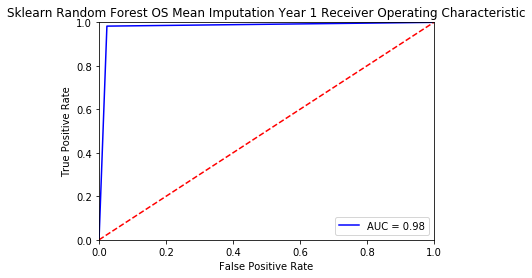

In [27]:
best_period = os_dfs_dict['mean'][0]
X = best_period.iloc[:,0:-1].values
y = best_period["Var66"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

random_forest_classifier_sklearn_roc = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

random_forest_classifier_sklearn_roc.fit(X_train, y_train)
y_pred_dt = random_forest_classifier_sklearn_roc.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_dt)
roc_auc = auc(fpr, tpr)

plt.title('Sklearn Random Forest OS Mean Imputation Year 1 Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




In [28]:
random_forest_classifier_sklearn_roc_all = RandomForestClassifier(criterion="gini", 
                                                          n_estimators = 10,
                                                          max_features = "sqrt", 
                                                          random_state = 94)

random_forest_classifier_sklearn_roc_all.fit(X, y)
y_pred_dt = random_forest_classifier_sklearn_roc_all.predict(x_test_f)

In [29]:
result = pd.DataFrame(y_pred_dt, columns=["Is_Bankrupted"])
upload = pd.concat([x_test_business_id, result], axis=1)
result["Is_Bankrupted"].value_counts()

0    1435
1      65
Name: Is_Bankrupted, dtype: int64

In [30]:
upload = upload.astype('int32')

In [31]:
upload.columns=['Business_ID', 'Is_Bankrupted']

In [34]:
upload.to_csv('3_17_2.csv', index=False)

In [33]:
upload.isnull().sum().sum()

0